In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.cm as cm
import os
import sys
import numpy as np
# load pkl file
import pickle
import seaborn as sns
import pandas as pd
import tamagotchi.eval.log_analysis as log_analysis
import matplotlib as mpl
from pybounds import colorline

# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/analyze_OL_perturb_trajj.ipynb
def tidx_around_wind_change(df_traj, around_range=40, drop_incomplete=True, drop_close_to_trial_init=False, verbose=False):
    # df_traj contains the KL divergence data and the time since the last wind change
    # get +- around_range index around which wind changed
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
        # drop_close_to_trial_init: plot_tidx marking is invalid if the wind change time is too close to the trial init, -40 plot_tidx could mean 0.8s from the last wind change
            # this option checks the lowest bound of the plot_tidx, if its corresponding time is less than 1s, drop the whole window
    idx_where_wind_changed = df_traj[df_traj['time_since_last_wind_change']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        # max_rep = np.max(np.array([int(hash.split('_')[-2]) for hash in df_traj['ep_idx']])) + 1
        # print(f"and up to {max_rep} reps")
        print(f"total number of wind change {len(idx_where_wind_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around wind change is out of range")
    
    # get index around which wind changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_wind_change_idx = []
    drop_due_to_close_to_trial_init = 0
    for _, ep_df in df_traj_grouped:
        idx_where_wind_changed = ep_df[ep_df['time_since_last_wind_change']==0].index
        for i, wind_changed_idx in enumerate(idx_where_wind_changed):
            # check if -5/+5 is out of range
            upper_bound = wind_changed_idx + around_range
            lower_bound = wind_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # check if the time elasped at the lower bound is too close to trial init
            if ep_df['time'].loc[lower_bound] < 1:
                if drop_close_to_trial_init:
                    drop_due_to_close_to_trial_init += 1
                    continue
            # check if time_since_last_wind_change is 0 at the lower bound
            if ep_df['time_since_last_wind_change'].loc[lower_bound] < 1:
                # print(f"wind_changed_idx {wind_changed_idx},  {ep_df['time_since_last_wind_change'].loc[lower_bound]}, lower_bound {lower_bound}, {wind_changed_idx - lower_bound}")
                continue
            # check if between lower_bound and wind_changed_idx, time_since_last_wind_change is not 0
            if 0 in ep_df['time_since_last_wind_change'].loc[lower_bound:wind_changed_idx-1].values:
                continue
            if 0 in ep_df['time_since_last_wind_change'].loc[wind_changed_idx+1:upper_bound].values:
                continue
            # get index around which wind changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - wind_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_wind_change_idx.append(wind_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_wind_change_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        print("trials dropped due to being too close to trial init", drop_due_to_close_to_trial_init)
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible wind change windows")
    return sub_df

def tidx_around_odor_contact(df_traj, around_range=5, drop_incomplete=True, verbose=False):
    # df_traj contains minEV zeta, ep_idx, odor_contact_start; currently only works if dropping incomplete, hence filling small gaps of 1 frame
    
    # get +- around_range index around which odor contact started or ended
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
    idx_where_odor_changed = df_traj[df_traj['odor_contact_start']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        print(f"total number of start of odor contact {len(idx_where_odor_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around odor change is out of range")
    
    # get index around which odor changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_odor_start_idx = []
    for _, ep_df in df_traj_grouped:
        idx_where_odor_changed = ep_df[ep_df['odor_contact_start']==1].index
        for odor_changed_idx in idx_where_odor_changed:
            # check if -5/+5 is out of range
            upper_bound = odor_changed_idx + around_range
            lower_bound = odor_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # get index around which odor changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            # check if that bleeds into other odor contact windows - TODO: currently only works if dropping incomplete
            assert drop_incomplete, "odor contact alignment only works if dropping incomplete for now"
            if (ep_df.loc[lower_bound:odor_changed_idx-1]['odor_01'].eq(1).any()): # if there is a 1 in the window
                # print(f"skip due to 1 in {ep_df.loc[lower_bound:odor_changed_idx-1]['odor_01']}")
                continue 
            elif (ep_df.loc[odor_changed_idx:upper_bound]['odor_01'].eq(0)).any(): # if there is a 0 in the window
                # print(f"skip due to 0 in {ep_df.loc[odor_changed_idx:upper_bound]['odor_01']}")
                continue
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - odor_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_odor_start_idx.append(odor_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_odor_start_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible odor contact windows")
    return sub_df



# spec plot what

In [21]:
plot_around_odor = True
plot_around_wind = False
filter_null = True
median = True
drop_close_to_trial_init = True
wind_around_range = 25
odor_around_range = 15
print(f"wind around range {wind_around_range*0.04}s, odor around range {odor_around_range*0.04}s")

wind around range 1.0, odor around range 0.6


# Plot!

now visualizing 24835, poisson_noisy3x5b5
Found 960 trials in observability results


960it [00:24, 39.32it/s]


(151321, 89)
(151321, 64)
window_size 7
dropping 960 rows, which are the last rows of each episode
filtered_df shape (150361, 100)
filtered_neural_activity shape (150361, 64)
(150361, 7)
Index(['time', 'time_initial', 'v_para', 'v_perp', 'w', 'zeta', 'ep_idx',
       'time_since_last_wind_change', 'odor_lastenc', 'odor_01', 'step',
       'turn', 'turn_abs', 'step_dt', 'step_dt_abs', 'turn_dt', 'turn_dt_abs',
       'loc_x', 'loc_y', 'wind_angle_ground_theta'],
      dtype='object')
(150361, 20)
window_length 7
wind around_range in time 1.0s
starting with df.shape (143641, 23)
with 960 eps
total number of wind change 3769
dropping incomplete time windows, where +- 25 around wind change is out of range
[NOTE]: number of eligible unique wind change instances 333
returning sub_df.shape (16983, 24)
with 260 eps
trials dropped due to being too close to trial init 356
eps {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32

960it [00:26, 36.54it/s]


(201973, 89)
(201973, 64)
window_size 6
dropping 960 rows, which are the last rows of each episode
filtered_df shape (201013, 100)
filtered_neural_activity shape (201013, 64)
(201013, 7)
Index(['time', 'time_initial', 'v_para', 'v_perp', 'w', 'zeta', 'ep_idx',
       'time_since_last_wind_change', 'odor_lastenc', 'odor_01', 'step',
       'turn', 'turn_abs', 'step_dt', 'step_dt_abs', 'turn_dt', 'turn_dt_abs',
       'loc_x', 'loc_y', 'wind_angle_ground_theta'],
      dtype='object')
(201013, 20)
window_length 6
wind around_range in time 1.0s
starting with df.shape (195253, 23)
with 960 eps
total number of wind change 5145
dropping incomplete time windows, where +- 25 around wind change is out of range
[NOTE]: number of eligible unique wind change instances 476
returning sub_df.shape (24276, 24)
with 351 eps
trials dropped due to being too close to trial init 349
eps {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32

960it [00:26, 36.81it/s]


(197303, 89)
(197303, 64)
window_size 8
dropping 960 rows, which are the last rows of each episode
filtered_df shape (196343, 100)
filtered_neural_activity shape (196343, 64)
(196343, 7)
Index(['time', 'time_initial', 'v_para', 'v_perp', 'w', 'zeta', 'ep_idx',
       'time_since_last_wind_change', 'odor_lastenc', 'odor_01', 'step',
       'turn', 'turn_abs', 'step_dt', 'step_dt_abs', 'turn_dt', 'turn_dt_abs',
       'loc_x', 'loc_y', 'wind_angle_ground_theta'],
      dtype='object')
(196343, 20)
window_length 8
wind around_range in time 1.0s
starting with df.shape (188663, 23)
with 960 eps
total number of wind change 4748
dropping incomplete time windows, where +- 25 around wind change is out of range
[NOTE]: number of eligible unique wind change instances 453
returning sub_df.shape (23103, 24)
with 310 eps
trials dropped due to being too close to trial init 344
eps {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32

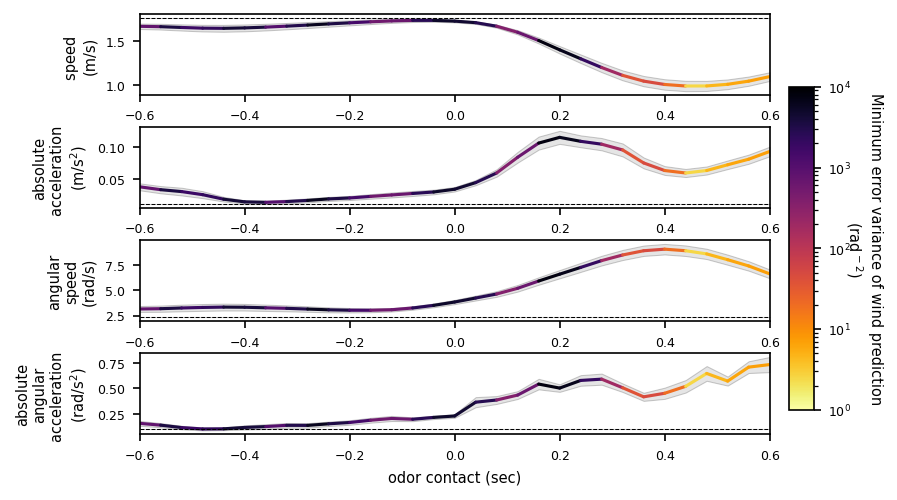

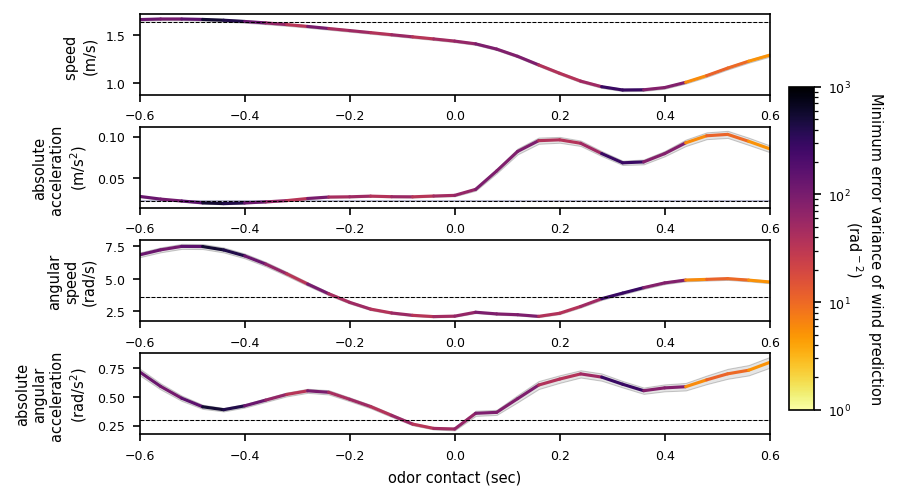

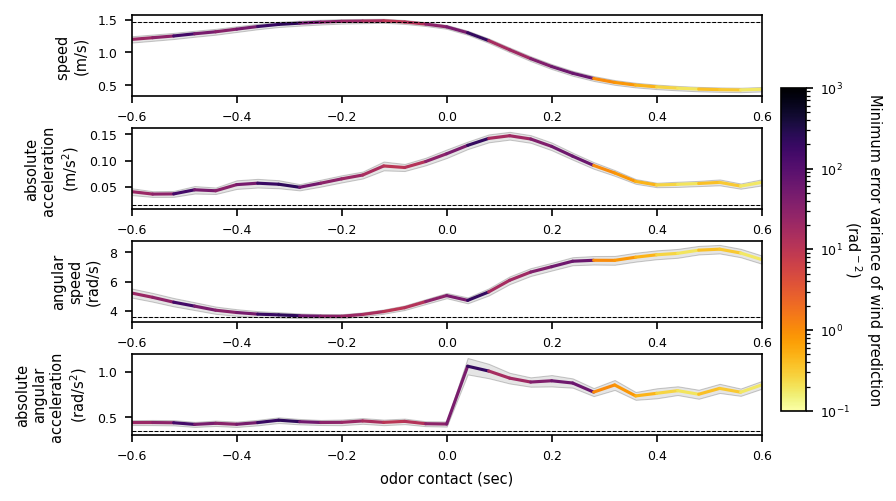

In [22]:
import re
outdir = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.01_train_std_pois_wind/eval/timing_by_quantile/'
# poisson_agents = ['plume_30011_9beecb563ff6757746898c0b75f0d7e7/poisson_noisy3x5b5.pkl',
poisson_agents = [
'plume_24835_5216f9b29f4bc2d9496619e9d2132553/poisson_noisy3x5b5.pkl',
'plume_21943_e03b9588604c41ee7292e64a5274bfc0/poisson_noisy3x5b5.pkl',
'plume_11848_abc2d820be42ae13fbdd73e28e3a04a4/poisson_noisy3x5b5.pkl']

obs_pkl_poisson_agents_all = [
'plume_24835_5216f9b29f4bc2d9496619e9d2132553/poisson_noisy3x5b5_w7_observability_test.pkl',
'plume_21943_e03b9588604c41ee7292e64a5274bfc0/poisson_noisy3x5b5_w6_observability_test.pkl',
'plume_11848_abc2d820be42ae13fbdd73e28e3a04a4/poisson_noisy3x5b5_w8_observability_test.pkl']

poisson_agent_folder = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.01_train_std_pois_wind/eval'
tmp = []
pkl = []
for i, agent in enumerate(poisson_agents):
    agent = os.path.join(poisson_agent_folder, agent)
    obs =  os.path.join(poisson_agent_folder, obs_pkl_poisson_agents_all[i])
    tmp.append(agent)
    pkl.append(obs)
obs_pkl_poisson_agents_all = pkl
poisson_agents = tmp


for agent_i, eval_pkl in enumerate(poisson_agents):
    obs_pkl = obs_pkl_poisson_agents_all[agent_i]   
    eval_folder = os.path.dirname(eval_pkl) + '/'
    dataset = os.path.basename(eval_pkl).replace('.pkl', '')

    model_name = os.path.basename(os.path.dirname(eval_folder)).split('_')[1]
    print(f"now visualizing {model_name}, {dataset}")
    # check if obs file exists
    if not os.path.exists(obs_pkl):
        print(f"Observability file {obs_pkl} not found")

    # with open(obs_pkls[0], 'rb') as f_handle:
    with open(obs_pkl, 'rb') as f_handle:
        observability_tupl = pickle.load(f_handle)
        print(f"Found {len(observability_tupl)} trials in observability results")
    # with open(eval_pkls[0], 'rb') as f_handle:
    with open(eval_pkl, 'rb') as f_handle:
        # based on open_loop_perturbation.py
        selected_df = log_analysis.get_selected_df(eval_folder, [dataset],
                                                n_episodes_home=960,
                                                n_episodes_other=960,   # when ploitting all
                                                # n_episodes_other=0,   # when only plotting HOME
                                                balanced=False,
                                                oob_only=False,
                                                verbose=False)

        traj_df_stacked, stacked_neural_activity = log_analysis.get_traj_and_activity_and_stack_them(selected_df, 
                                                                                                    obtain_neural_activity = True, 
                                                                                                    obtain_traj_df = True, 
                                                                                                    get_traj_tmp = True,
                                                                                                    extended_metadata = True) # get_traj_tmp 
        print(traj_df_stacked.shape)
        print(stacked_neural_activity.shape)
    for item in observability_tupl:
        EV_no_nan, t_sim, x_sim, window_size, eps_idx = item
        
    ls_EV_no_nan, ls_t_sim, ls_x_sim, ls_window_size, ls_eps_idx = zip(*observability_tupl)
    window_size = list(set(ls_window_size))[0]
    print("window_size", window_size)
    # Preprocess the trajectory data
    # select episodes that have observability matrices
    eps_at = [True for ep_i in traj_df_stacked['ep_idx'] ]
    subset_traj_df_stacked = traj_df_stacked[eps_at]
    subset_stacked_neural_activity = stacked_neural_activity[eps_at]

    # for every episode, drop the last row
    subset_traj_df_stacked.reset_index(drop=True, inplace=True)
    last_rows = subset_traj_df_stacked.groupby('ep_idx').tail(1).index
    print('dropping', len(last_rows), 'rows, which are the last rows of each episode') # drop because there's no terminal+1 state
    # drop the last row of each episode
    filtered_df = subset_traj_df_stacked.drop(index=last_rows)
    filtered_neural_activity = np.delete(subset_stacked_neural_activity, last_rows, axis=0)

    # calculate time since last wind change
        # based on /src/JH_boilerplate/agent_evaluatiion/traj_analysis_preprocess.ipynb
    filtered_df = filtered_df.groupby('ep_idx').apply(log_analysis.calc_time_since_last_wind_change).reset_index(drop=True)

    # # create time column in filtered_df to match with EV_no_nan, starting from 0 to trial end 
    filtered_df['time'] = filtered_df.groupby('ep_idx')['t_val'].transform(lambda x: x - x.iloc[0])
    filtered_df['time'] = filtered_df['time'].round(2)
    filtered_df['turn'] = (filtered_df['turn'] * 2) - 1 # center the turn values at 0 (from 0~1 to -1~1)
    filtered_df['turn_abs'] = filtered_df['turn'].abs()

    # first derivative of actions based on obs_df calculations 
    filtered_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)
    filtered_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))
    filtered_df['angular_velocity'] = filtered_df.groupby('ep_idx')['heading_phi_unwrap'].diff() # not really v - just once step difference
    filtered_df['angular_acceleration'] = filtered_df.groupby('ep_idx')['angular_velocity'].diff()
    filtered_df['turn_dt'] = filtered_df['angular_acceleration'] / (6 * np.pi * 0.04) # given angular acceleration, calculate turn_dt, i.e. chaneg in turn action 
    filtered_df['turn_dt_abs'] = filtered_df['turn_dt'].abs() 
    filtered_df['step_dt'] = filtered_df.groupby('ep_idx')['step'].diff()
    filtered_df['step_dt_abs'] = filtered_df['step_dt'].abs()

    # drop rows with NaN
    # filtered_df.dropna(inplace=True)

    print("filtered_df shape", filtered_df.shape)
    print("filtered_neural_activity shape", filtered_neural_activity.shape)

    # Preprocess the EV data 
    # stack the EV data
    ls_EV_no_nan = [df.assign(ep_idx=ep_idx) for df, ep_idx in zip(ls_EV_no_nan, ls_eps_idx)]
    EV_no_nan = pd.concat(ls_EV_no_nan)
    print(EV_no_nan.shape)
    # Merge with filtered_dfa
    EV_no_nan['time'] = EV_no_nan['time'].round(2)
    EV_no_nan = EV_no_nan.merge(filtered_df[['ep_idx', 'time', 'time_since_last_wind_change', 
                                            'odor_lastenc', 'odor_01', 'step', 'turn', 'turn_abs', 'step_dt', 'step_dt_abs', 
                                            'turn_dt', 'turn_dt_abs', 'loc_x', 'loc_y', 'wind_angle_ground_theta']], 
                                on=['ep_idx', 'time'], how='inner')


    EV_no_nan_shifted = EV_no_nan.copy()
    print(EV_no_nan_shifted.columns)
    print(EV_no_nan_shifted.shape)
    ##########################################################################################
    ######                         SHIFT DATAFRAME BY EV WINDOW                         ######
    ##########################################################################################
    window_length = window_size
    print(f"window_length {window_length}")


    EV_no_nan_shifted['zeta_shifted'] = EV_no_nan_shifted.groupby('ep_idx')['zeta'].shift(int(window_length/2))
    EV_no_nan_shifted['zeta_shifted_qcut'] = EV_no_nan_shifted['zeta_shifted'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    EV_no_nan_shifted['zeta_shifted_qcut_per_eps'] = EV_no_nan_shifted.groupby('ep_idx')['zeta_shifted'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    # drop the first 10 idx in each episode
    EV_no_nan_shifted = EV_no_nan_shifted.groupby('ep_idx').apply(lambda x: x.iloc[window_length:])
    EV_no_nan_shifted = EV_no_nan_shifted.droplevel(0)
    wind_around_range = 25
    print(f"wind around_range in time {wind_around_range*0.04}s")
    
    if plot_around_wind:    
        EV_no_nan_shifted_around = tidx_around_wind_change(EV_no_nan_shifted, around_range=wind_around_range, drop_incomplete=True, drop_close_to_trial_init=drop_close_to_trial_init, verbose=True)
        if EV_no_nan_shifted_around.shape[0] == 0:
            print(f"No eligible wind change instances found \n\n\n\n\n {model_name}")
            continue
        ##########################################################################################
        ######                    PLOT OBS AND ACTION AROUND WIND CHANGE                    ######
        ##########################################################################################
    
        null_df = EV_no_nan_shifted.copy() # get the average actions 
        if filter_null: # only include eps that have trials around the wind change
            EV_eps = EV_no_nan_shifted_around['ep_idx'].unique()
            null_df = null_df[null_df['ep_idx'].isin(EV_eps)]
        EV_eps = EV_no_nan_shifted['ep_idx'].unique() # include all eps, whether they had eligible wind change windows or not
        null_df['turn_abs'] = np.abs(null_df['turn'])
        if median:
            null_df = null_df[['step', 'turn', 'turn_abs', 'step_dt', 'step_dt_abs', 'turn_dt', 'turn_dt_abs']].median().reset_index()
        else:
            null_df = null_df[['step', 'turn', 'turn_abs', 'step_dt', 'step_dt_abs', 'turn_dt', 'turn_dt_abs']].mean().reset_index()
            
        null_df.index = null_df['index']
        # drop index col
        null_df.drop(columns='index', inplace=True)

        null_df.loc['step'] = null_df.loc['step'] * 2
        null_df.loc['turn'] = null_df.loc['turn'] * 6 * np.pi
        null_df.loc['turn_abs'] = null_df.loc['turn_abs'] * 6 * np.pi
        null_df.loc['step_dt'] = null_df.loc['step_dt'] * 2
        null_df.loc['turn_dt'] = null_df.loc['turn_dt'] * 6 * np.pi
        null_df.loc['step_dt_abs'] = null_df.loc['step_dt_abs'] * 2
        null_df.loc['turn_dt_abs'] = null_df.loc['turn_dt_abs'] * 6 * np.pi

        null_df.loc['ste_step'] = EV_no_nan_shifted.std()['step'] * 2 / np.sqrt(len(EV_eps))
        null_df.loc['ste_step_dt'] = EV_no_nan_shifted.std()['step_dt'] * 2 / np.sqrt(len(EV_eps))
        null_df.loc['ste_step_dt_abs'] = EV_no_nan_shifted.std()['step_dt_abs'] * 2 / np.sqrt(len(EV_eps))
        null_df.loc['ste_turn'] = EV_no_nan_shifted.std()['turn'] * 6 * np.pi / np.sqrt(len(EV_eps))
        null_df.loc['ste_turn_abs'] = EV_no_nan_shifted.std()['turn_abs'] * 6 * np.pi / np.sqrt(len(EV_eps))
        null_df.loc['ste_turn_dt'] = EV_no_nan_shifted.std()['turn_dt'] * 6 * np.pi / np.sqrt(len(EV_eps))
        null_df.loc['ste_turn_dt_abs'] = EV_no_nan_shifted.std()['turn_dt_abs'] * 6 * np.pi / np.sqrt(len(EV_eps))

        null_df.loc['ste_step'] = EV_no_nan_shifted.sem()['step'] * 2 
        null_df.loc['ste_step_dt'] = EV_no_nan_shifted.sem()['step_dt'] * 2 
        null_df.loc['ste_step_dt_abs'] = EV_no_nan_shifted.sem()['step_dt_abs'] * 2 
        null_df.loc['ste_turn'] = EV_no_nan_shifted.sem()['turn'] * 6 
        null_df.loc['ste_turn_abs'] = EV_no_nan_shifted.sem()['turn_abs'] * 6 
        null_df.loc['ste_turn_dt'] = EV_no_nan_shifted.sem()['turn_dt'] * 6 
        null_df.loc['ste_turn_dt_abs'] = EV_no_nan_shifted.sem()['turn_dt_abs'] * 6 

        print(null_df)

        import matplotlib.pyplot as plt
        import matplotlib as mpl
        from pybounds import colorline

        ylabl_title = {'step': 'speed \n(m/s)', 
                        'step_dt': 'absolute\nacceleration \n(m/s$^2$)', 
                        'step_dt_abs': 'absolute\nacceleration \n(m/s$^2$)', 
                    'turn': 'angular\nvelocity\n(rad/s)',
                    'turn_abs': 'angular\nspeed\n(rad/s)',
                    'turn_dt': 'absolute\nangular\nacceleration \n(rad/s$^2$)',
                    'turn_dt_abs': 'absolute\nangular\nacceleration \n(rad/s$^2$)'}

        # plot average of actions over time since last wind change
        # plot average EV over time since last wind change with std ON plume
        tmp = EV_no_nan_shifted_around.copy() # scale actions by physical units
        tmp['step'] = tmp['step'] * 2
        tmp['turn'] = tmp['turn'] * 6 * np.pi
        tmp['step_dt'] = tmp['step_dt'] * 2
        tmp['step_dt_abs'] = tmp['step_dt_abs'] * 2
        tmp['turn_dt'] = tmp['turn_dt'] * 6 * np.pi
        tmp['turn_dt_abs'] = tmp['turn_dt_abs'] * 6 * np.pi
        tmp['turn_abs'] = tmp['turn'].abs()
        if median:
            subset_df = tmp.groupby('plot_tidx')[['zeta_shifted', 'step', 'turn', 'turn_abs', 'step_dt', 'turn_dt', 'step_dt_abs', 'turn_dt_abs']].median().reset_index()
        else:
            subset_df = tmp.groupby('plot_tidx')[['zeta_shifted', 'step', 'turn', 'turn_abs', 'step_dt', 'turn_dt', 'step_dt_abs', 'turn_dt_abs']].mean().reset_index()
        # print(subset_df[10:30])
        # dispersion std
        subset_df['std_zeta_shifted'] = tmp.groupby('plot_tidx').std().reset_index()['zeta_shifted']
        subset_df['std_step'] = tmp.groupby('plot_tidx').std().reset_index()['step']
        subset_df['std_step_dt'] = tmp.groupby('plot_tidx').std().reset_index()['step_dt'] 
        subset_df['std_step_dt_abs'] = tmp.groupby('plot_tidx').std().reset_index()['step_dt_abs'] 
        subset_df['std_turn'] = tmp.groupby('plot_tidx').std().reset_index()['turn'] 
        subset_df['std_turn_dt'] = tmp.groupby('plot_tidx').std().reset_index()['turn_dt'] 
        subset_df['std_turn_dt_abs'] = tmp.groupby('plot_tidx').std().reset_index()['turn_dt_abs'] 
        # dispersion ste
        subset_df['ste_zeta_shifted'] = tmp.groupby('plot_tidx').sem().reset_index()['zeta_shifted']
        subset_df['ste_step'] = tmp.groupby('plot_tidx').sem().reset_index()['step'] 
        subset_df['ste_step_dt'] = tmp.groupby('plot_tidx').sem().reset_index()['step_dt'] 
        subset_df['ste_step_dt_abs'] = tmp.groupby('plot_tidx').sem().reset_index()['step_dt_abs'] 
        subset_df['ste_turn'] = tmp.groupby('plot_tidx').sem().reset_index()['turn'] 
        subset_df['ste_turn_abs'] = tmp.groupby('plot_tidx').sem().reset_index()['turn_abs'] 
        subset_df['ste_turn_dt'] = tmp.groupby('plot_tidx').sem().reset_index()['turn_dt'] 
        subset_df['ste_turn_dt_abs'] = tmp.groupby('plot_tidx').sem().reset_index()['turn_dt_abs'] 
        # x-axis
        subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04

        states = ['step', 'step_dt_abs', 'turn', 'turn_dt_abs' ]
        # states = ['step', 'step_dt', 'turn', 'turn_dt' ]
        n_state = len(states)

        fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
        ax = np.atleast_2d(ax)
        ax = ax.reshape(-1, 1)
        print(ax.shape)
        cmap = 'inferno_r'
        color_by = 'zeta_shifted'

        # max, min, log, ticks for the colorbar
        max_ev = np.max(subset_df[color_by].values)
        min_ev = np.min(subset_df[color_by].values)
        log_tick_high = int(np.ceil(np.log10(max_ev)))
        log_tick_low = int(np.floor(np.log10(min_ev)))
        print(f"max_ev {max_ev}, min_ev {min_ev}, log_tick_high {log_tick_high}, log_tick_low {log_tick_low}")
        cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

        for n, state_name in enumerate(states):
            dispersion_col = 'ste_' + state_name
            colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
                    ax=ax[n, 0], cmap=cmap, norm=cnorm)
            # add std
            ax[n, 0].fill_between(subset_df['plot_tidx'], 
                                subset_df[state_name].values-subset_df[dispersion_col], 
                                subset_df[state_name].values+subset_df[dispersion_col], 
                                alpha=0.2,
                                color='grey',
                                edgecolor='black',
                                linewidth=0.5)   
            # Colorbar
            if n == 1:
                cax = ax[n, -1].inset_axes([1.03, -2.5, 0.04, 4.0])
                cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                                    ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
                cbar.set_label('Minimum error variance of wind prediction\n' + r'(rad$^-$$^2$)', rotation=270, fontsize=7, labelpad=15)
                cbar.ax.tick_params(labelsize=6)

            # set y label
            ax[n, 0].set_ylabel(ylabl_title[state_name], fontsize=7)
            
            # add null line
            ax[n, 0].axhline(null_df.loc[state_name][0], color='black', linestyle='--', linewidth=0.5)
            # add null std
            ax[n, 0].fill_between(subset_df['plot_tidx'], 
                                null_df.loc[state_name][0]-null_df.loc['ste_'+state_name][0], 
                                null_df.loc[state_name][0]+null_df.loc['ste_'+state_name][0], 
                                alpha=0.2,
                                color='blue',
                                edgecolor='black',
                                linewidth=0.5)

        for a in ax.flat:
            a.tick_params(axis='both', labelsize=6)
            
        for i, a in enumerate(ax[:, 0]):
            if i == len(states) - 1:
                a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
            a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max())
        fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9, wspace=0.5, hspace=0.4)

        outdir = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.01_train_std_pois_wind/eval/observability/'
        if drop_close_to_trial_init:
            fname = f"{outdir}/{model_name}_around_{wind_around_range}_drop_close_to_trial_init.png"
        else:
            fname = f"{outdir}/{model_name}_around_{wind_around_range}.png"
        if median:
            fname = fname.replace('.png', '_median.png')
        fig.savefig(fname)
    
    if plot_around_odor:
        ##########################################################################################
        ######                       PREPROCESS AROUND ODOR CONTACT                         ######
        ##########################################################################################
        # based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/anno_around_plume_contact.ipynb

        # find segments of continous odor contact, after filling the small gaps; NOTE: Start with ep_idx, odor_01, odor_lastenc, time
        # 0. for every eps, find on-plume rows
        EV_no_nan_on_plume = EV_no_nan_shifted.groupby('ep_idx', as_index=False).apply(lambda x: x[x['odor_01'] == 1])
        EV_no_nan_on_plume.index = [i[1] for i in EV_no_nan_on_plume.index] # drop the eps_index level of the multiindex
        # 1. fill plume enc gaps that are 1 timestep long
        # check if there are any gaps in the plume encodings - how far apart are the on-plume timesteps?
        delta_t_val = EV_no_nan_on_plume.groupby('ep_idx')['time'].diff()
        delta_t_val.fillna(0.04, inplace=True) # first step in each episode is always 0.04 so fill na
        delta_t_val = delta_t_val.round(2) # round to 2 decimal places such that all 0.04 are the same
        tol_odor_gap_steps = 1 # 1 step gap is allowed during plume enc
        idx_small_gaps_to_fill = delta_t_val[delta_t_val == 0.04*(tol_odor_gap_steps+1)].index # if within tolerance, consider it as 0.04
        # the actual filling of the gaps
        if EV_no_nan_on_plume.loc[idx_small_gaps_to_fill]['odor_01'].sum() == 0:
            print('as expected, all gaps have no odor')
        EV_no_nan_on_plume.loc[idx_small_gaps_to_fill]['odor_lastenc'] == tol_odor_gap_steps
        EV_no_nan_on_plume.loc[idx_small_gaps_to_fill]['odor_01'] = 1

        # 2. find segments of continous odor contact, after filling the small gaps
            # goal # pull out indices of the start and end of the plume encounter
        ls_odor_contact_start = []
        ls_odor_contact_end = []
        end_of_section_idx = [i for i in delta_t_val[delta_t_val != 0.04].index] 
        for now_eps, group_df in EV_no_nan_shifted.groupby('ep_idx', as_index=False): # do this per eps to ensure there's no cross over of eps
            curr_marks = [i for i in end_of_section_idx if i < group_df.index.max() and i > group_df.index.min()]
            session_start = [group_df.index.min(), *curr_marks]
            session_end = [*curr_marks, group_df.index.max()]
            for i, now_section_idx in enumerate(zip(session_start, session_end)): # each session contains one segment of continuous odor contact
                section_df = group_df.loc[now_section_idx[0]:now_section_idx[1]-1] # .loc is end inclusive - so remove 1 to exclude the first ts of next odor encounter    
                plume_enc_df = section_df[section_df['odor_01'] == 1] # each section contains one continuous plume encounter
                if not plume_enc_df.empty:
                    # pull out indices of the start and end of the plume encounter
                    odor_contact_start = plume_enc_df.index[0]
                    odor_contact_end = plume_enc_df.index[-1]
                    ls_odor_contact_start.append(odor_contact_start)
                    ls_odor_contact_end.append(odor_contact_end)
                    # # SANITY CHECK PASSED around the plume encounter, there should not be any odor, if those steps are in the same episode as the plume encounter
                    # if i:
                    #     start_minus_one = group_df.loc[odor_contact_start - 1]
                    #     assert start_minus_one['odor_01'] == 0, f"the step before odor encounter df {now_section_idx} {start_minus_one} is on odor!"
                    # end_plus_one = traj_df_stacked.loc[odor_contact_end + 1]
                    # if end_plus_one['ep_idx'] == now_eps:
                    #     if (odor_contact_end + 1) != group_df.index.max(): # last step is cut off - it could be on plume. This is fine
                    #         assert end_plus_one['odor_01'] == 0, f"the step after end of odor encounter df {now_section_idx} {end_plus_one} is on odor!"
                    #     # the step after end of odor encounter df (704, 707) loc_x   


        odor_around_range = 15
        # add cols for tidx_around_odor_contact
        EV_no_nan_around_odor_shifted = EV_no_nan_shifted.copy()
        EV_no_nan_around_odor_shifted['odor_contact_start'] = 0
        EV_no_nan_around_odor_shifted['odor_contact_end'] = 0
        EV_no_nan_around_odor_shifted.loc[ls_odor_contact_start, 'odor_contact_start'] = 1
        EV_no_nan_around_odor_shifted.loc[ls_odor_contact_end, 'odor_contact_end'] = 1
        # tidx_around_odor_contact
        EV_no_nan_around_odor_shifted = tidx_around_odor_contact(EV_no_nan_around_odor_shifted, around_range=odor_around_range, drop_incomplete=True, verbose=True)
        print(f"odor around_range in time {odor_around_range*0.04}s")
        ##########################################################################################
        ######                    PLOT OBS AND ACTION AROUND WIND CHANGE                    ######
        ##########################################################################################
        null_df = EV_no_nan_shifted.copy() # get the average actions 

        if filter_null: # only include eps that have trials around the wind change
            EV_eps = EV_no_nan_around_odor_shifted['ep_idx'].unique()
            null_df = null_df[null_df['ep_idx'].isin(EV_eps)]
        EV_eps = EV_no_nan_shifted['ep_idx'].unique() # include all eps, whether they had eligible wind change windows or not
        null_df['turn_abs'] = np.abs(null_df['turn'])
        if median:
            null_df = null_df[['step', 'turn', 'turn_abs', 'step_dt', 'step_dt_abs', 'turn_dt', 'turn_dt_abs']].median().reset_index()
        else:
            null_df = null_df[['step', 'turn', 'turn_abs', 'step_dt', 'step_dt_abs', 'turn_dt', 'turn_dt_abs']].mean().reset_index()
            
        null_df.index = null_df['index']
        # drop index col
        null_df.drop(columns='index', inplace=True)

        null_df.loc['step'] = null_df.loc['step'] * 2
        null_df.loc['turn'] = null_df.loc['turn'] * 6 * np.pi
        null_df.loc['turn_abs'] = null_df.loc['turn_abs'] * 6 * np.pi
        null_df.loc['step_dt'] = null_df.loc['step_dt'] * 2
        null_df.loc['turn_dt'] = null_df.loc['turn_dt'] * 6 * np.pi
        null_df.loc['step_dt_abs'] = null_df.loc['step_dt_abs'] * 2
        null_df.loc['turn_dt_abs'] = null_df.loc['turn_dt_abs'] * 6 * np.pi

        null_df.loc['ste_step'] = EV_no_nan_shifted.std()['step'] * 2 / np.sqrt(len(EV_eps))
        null_df.loc['ste_step_dt'] = EV_no_nan_shifted.std()['step_dt'] * 2 / np.sqrt(len(EV_eps))
        null_df.loc['ste_step_dt_abs'] = EV_no_nan_shifted.std()['step_dt_abs'] * 2 / np.sqrt(len(EV_eps))
        null_df.loc['ste_turn'] = EV_no_nan_shifted.std()['turn'] * 6 * np.pi / np.sqrt(len(EV_eps))
        null_df.loc['ste_turn_abs'] = EV_no_nan_shifted.std()['turn_abs'] * 6 * np.pi / np.sqrt(len(EV_eps))
        null_df.loc['ste_turn_dt'] = EV_no_nan_shifted.std()['turn_dt'] * 6 * np.pi / np.sqrt(len(EV_eps))
        null_df.loc['ste_turn_dt_abs'] = EV_no_nan_shifted.std()['turn_dt_abs'] * 6 * np.pi / np.sqrt(len(EV_eps))


        null_df.loc['ste_step'] = EV_no_nan_shifted.sem()['step'] * 2 
        null_df.loc['ste_step_dt'] = EV_no_nan_shifted.sem()['step_dt'] * 2 
        null_df.loc['ste_step_dt_abs'] = EV_no_nan_shifted.sem()['step_dt_abs'] * 2 
        null_df.loc['ste_turn'] = EV_no_nan_shifted.sem()['turn'] * 6 
        null_df.loc['ste_turn_abs'] = EV_no_nan_shifted.sem()['turn_abs'] * 6 
        null_df.loc['ste_turn_dt'] = EV_no_nan_shifted.sem()['turn_dt'] * 6 
        null_df.loc['ste_turn_dt_abs'] = EV_no_nan_shifted.sem()['turn_dt_abs'] * 6 
            

        # plot average of actions over time since last wind change
        # plot average EV over time since last wind change with std ON plume
        tmp = EV_no_nan_around_odor_shifted.copy() # scale actions by physical units
        tmp['step'] = tmp['step'] * 2
        tmp['turn'] = tmp['turn'] * 6 * np.pi
        tmp['step_dt'] = tmp['step_dt'] * 2
        tmp['step_dt_abs'] = tmp['step_dt_abs'] * 2
        tmp['turn_dt'] = tmp['turn_dt'] * 6 * np.pi
        tmp['turn_dt_abs'] = tmp['turn_dt_abs'] * 6 * np.pi
        # tmp['step_dt'] = tmp['step_dt'].abs() # absolute value
        # tmp['turn_dt'] = tmp['turn_dt'].abs()
        tmp['turn_abs'] = tmp['turn'].abs()

        if median:
            subset_df = tmp.groupby('plot_tidx')[['zeta_shifted', 'step', 'turn', 'turn_abs', 'step_dt', 'turn_dt', 'step_dt_abs', 'turn_dt_abs']].mean().reset_index()
        else:
            subset_df = tmp.groupby('plot_tidx')[['zeta_shifted', 'step', 'turn', 'turn_abs', 'step_dt', 'turn_dt', 'step_dt_abs', 'turn_dt_abs']].mean().reset_index()
        # print(subset_df[10:30])
        # dispersion std
        subset_df['std_zeta_shifted'] = tmp.groupby('plot_tidx').std().reset_index()['zeta_shifted']
        subset_df['std_step'] = tmp.groupby('plot_tidx').std().reset_index()['step']
        subset_df['std_step_dt'] = tmp.groupby('plot_tidx').std().reset_index()['step_dt']
        subset_df['std_step_dt_abs'] = tmp.groupby('plot_tidx').std().reset_index()['step_dt_abs']
        subset_df['std_turn'] = tmp.groupby('plot_tidx').std().reset_index()['turn']
        subset_df['std_turn_dt'] = tmp.groupby('plot_tidx').std().reset_index()['turn_dt']
        subset_df['std_turn_dt_abs'] = tmp.groupby('plot_tidx').std().reset_index()['turn_dt_abs']
        # dispersion ste
        subset_df['ste_zeta_shifted'] = tmp.groupby('plot_tidx').sem().reset_index()['zeta_shifted']
        subset_df['ste_step'] = tmp.groupby('plot_tidx').sem().reset_index()['step']
        subset_df['ste_step_dt'] = tmp.groupby('plot_tidx').sem().reset_index()['step_dt']
        subset_df['ste_step_dt_abs'] = tmp.groupby('plot_tidx').sem().reset_index()['step_dt_abs']
        subset_df['ste_turn'] = tmp.groupby('plot_tidx').sem().reset_index()['turn']
        subset_df['ste_turn_abs'] = tmp.groupby('plot_tidx').sem().reset_index()['turn_abs']
        subset_df['ste_turn_dt'] = tmp.groupby('plot_tidx').sem().reset_index()['turn_dt']
        subset_df['ste_turn_dt_abs'] = tmp.groupby('plot_tidx').sem().reset_index()['turn_dt_abs']
        # x-axis
        subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04

        states = ['step', 'step_dt_abs', 'turn_abs', 'turn_dt_abs' ]
        # states = ['step', 'step_dt', 'turn', 'turn_dt' ]
        n_state = len(states)

        fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
        ax = np.atleast_2d(ax)
        ax = ax.reshape(-1, 1)
        print(ax.shape)
        cmap = 'inferno_r'
        color_by = 'zeta_shifted'

        # max, min, log, ticks for the colorbar
        max_ev = np.max(subset_df[color_by].values)
        min_ev = np.min(subset_df[color_by].values)
        log_tick_high = int(np.ceil(np.log10(max_ev)))
        log_tick_low = int(np.floor(np.log10(min_ev)))
        print(f"max_ev {max_ev}, min_ev {min_ev}, log_tick_high {log_tick_high}, log_tick_low {log_tick_low}")
        cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

        for n, state_name in enumerate(states):
            dispersion_col = 'ste_' + state_name
            colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
                    ax=ax[n, 0], cmap=cmap, norm=cnorm)
            # add std
            ax[n, 0].fill_between(subset_df['plot_tidx'], 
                                subset_df[state_name].values-subset_df[dispersion_col], 
                                subset_df[state_name].values+subset_df[dispersion_col], 
                                alpha=0.2,
                                color='grey',
                                edgecolor='black',
                                linewidth=0.5)   
            # Colorbar
            if n == 1:
                cax = ax[n, -1].inset_axes([1.03, -2.5, 0.04, 4.0])
                cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                                    ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
                cbar.set_label('Minimum error variance of wind prediction\n' + r'(rad$^-$$^2$)', rotation=270, fontsize=7, labelpad=15)
                cbar.ax.tick_params(labelsize=6)

            # set y label
            ax[n, 0].set_ylabel(ylabl_title[state_name], fontsize=7)
            
            # add null line
            ax[n, 0].axhline(null_df.loc[state_name][0], color='black', linestyle='--', linewidth=0.5)
            # add null std
            ax[n, 0].fill_between(subset_df['plot_tidx'], 
                                null_df.loc[state_name][0]-null_df.loc['ste_'+state_name][0], 
                                null_df.loc[state_name][0]+null_df.loc['ste_'+state_name][0], 
                                alpha=0.2,
                                color='blue',
                                edgecolor='black',
                                linewidth=0.5)

        for a in ax.flat:
            a.tick_params(axis='both', labelsize=6)
            
        for i, a in enumerate(ax[:, 0]):
            if i == len(states) - 1:
                a.set_xlabel('odor contact (sec)', fontsize=7)
            a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max())
        fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9, wspace=0.5, hspace=0.4)

        # plt.show()
        # outdir = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.01_train_std_pois_wind/eval/observability/'
        if drop_close_to_trial_init:
            fname = f"{outdir}/{model_name}_around_odor_{odor_around_range}_drop_close_to_trial_init.png"
        else:
            fname = f"{outdir}/{model_name}_around_odor_{odor_around_range}.png"
        if median:
            fname = fname.replace('.png', '_median.png')
        # fname = f"{outdir}/{model_name}_around_{around_range}_drop_close_to_trial_init"
        fig.savefig(fname)



# without null

In [ ]:
    # ylabl_title = {'step': 'speed \n(m/s)', 
    #                 'step_dt': 'acceleration \n(m/s$^2$)', 
    #             'turn': 'angular\nvelocity\n(rad/s)',
    #             'turn_dt': 'angular\nacceleration \n(rad/s$^2$)'}

    # # plot average of actions over time since last wind change
    # # plot average EV over time since last wind change with std ON plume
    # tmp = EV_no_nan_shifted_around.copy() # scale actions by physical units
    # tmp['step'] = tmp['step'] * 2
    # tmp['turn'] = tmp['turn'] * 6 * np.pi
    # tmp['step_dt'] = tmp['step_dt'] * 2
    # tmp['turn_dt'] = tmp['turn_dt'] * 6 * np.pi
    # tmp['step_dt'] = tmp['step_dt'].abs() # absolute value
    # tmp['turn_dt'] = tmp['turn_dt'].abs()
    # tmp['turn'] = tmp['turn'].abs()

    # subset_df = tmp.groupby('plot_tidx')[['zeta_shifted', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
    # # print(subset_df[10:30])
    # # dispersion std
    # subset_df['std_zeta_shifted'] = tmp.groupby('plot_tidx').std().reset_index()['zeta_shifted']
    # subset_df['std_step'] = tmp.groupby('plot_tidx').std().reset_index()['step']
    # subset_df['std_step_dt'] = tmp.groupby('plot_tidx').std().reset_index()['step_dt']
    # subset_df['std_turn'] = tmp.groupby('plot_tidx').std().reset_index()['turn']
    # subset_df['std_turn_dt'] = tmp.groupby('plot_tidx').std().reset_index()['turn_dt']
    # # dispersion ste
    # subset_df['ste_zeta_shifted'] = tmp.groupby('plot_tidx').sem().reset_index()['zeta_shifted']
    # subset_df['ste_step'] = tmp.groupby('plot_tidx').sem().reset_index()['step']
    # subset_df['ste_step_dt'] = tmp.groupby('plot_tidx').sem().reset_index()['step_dt']
    # subset_df['ste_turn'] = tmp.groupby('plot_tidx').sem().reset_index()['turn']
    # subset_df['ste_turn_dt'] = tmp.groupby('plot_tidx').sem().reset_index()['turn_dt']
    # # x-axis
    # subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
    # # states = ['step', 'turn', 'step_dt', 'turn_dt']
    # states = ['step', 'step_dt', 'turn', 'turn_dt' ]
    # n_state = len(states)

    # fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
    # ax = np.atleast_2d(ax)
    # ax = ax.reshape(-1, 1)
    # print(ax.shape)
    # cmap = 'inferno_r'
    # color_by = 'zeta_shifted'

    # # max, min, log, ticks for the colorbar
    # max_ev = np.max(subset_df[color_by].values)
    # min_ev = np.min(subset_df[color_by].values)
    # log_tick_high = int(np.ceil(np.log10(max_ev)))
    # log_tick_low = int(np.floor(np.log10(min_ev)))
    # print(f"max_ev {max_ev}, min_ev {min_ev}, log_tick_high {log_tick_high}, log_tick_low {log_tick_low}")
    # cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

    # for n, state_name in enumerate(states):
    #     dispersion_col = 'ste_' + state_name
    #     # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    #     colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
    #             ax=ax[n, 0], cmap=cmap, norm=cnorm)
    #     # add std
    #     ax[n, 0].fill_between(subset_df['plot_tidx'], 
    #                         subset_df[state_name].values-subset_df[dispersion_col], 
    #                         subset_df[state_name].values+subset_df[dispersion_col], 
    #                         alpha=0.2,
    #                         #   hatch='|',
    #                         color='grey',
    #                         edgecolor='black',
    #                         linewidth=0.5)   
    #     # Colorbar
    #     if n == 1:
    #         cax = ax[n, -1].inset_axes([1.03, -2.5, 0.04, 4.0])
    #         cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
    #                             ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    #         cbar.set_label('Minimum error variance of wind prediction\n' + r'(rad$^-$$^2$)', rotation=270, fontsize=7, labelpad=15)
    #         cbar.ax.tick_params(labelsize=6)

    #     # set y label
    #     ax[n, 0].set_ylabel(ylabl_title[state_name], fontsize=7)

    # for a in ax.flat:
    #     a.tick_params(axis='both', labelsize=6)
        
    # for i, a in enumerate(ax[:, 0]):
    #     if i == len(states) - 1:
    #         a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    #     a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max())
    # fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9, wspace=0.5, hspace=0.4)
